# Medical Expenditure Panel Survey

This is explanatory analysis of medical expenses related to medical treatments. This is a regression problem.
In this work I trained and compared 2 models:
- Gradient Boosting Regressor
- Random Forest Regressor

Health Expenses were also limited to maximum of 150k$.

For the explanations I have selected variables:
- __PCS42__: PHY COMPONENT SUMMRY SF-12V2 IMPUTED
- __MCS42__: MNT COMPONENT SUMMRY SF-12V2 IMPUTED
- __K6SUM42__: SAQ 30 DAYS: OVERALL RATING OF FEELINGS
- __PHQ242__: SAQ 2 WKS: OVERALL RATING OF FEELINGS
- __ARTHYPE__: TYPE OF ARTHRITIS DIAGNOSED
- __INCOME_M__: ANNUAL INCOME
- __CANCERDX__: CANCER DIAGNOSIS
- __AGE31X__: AGE - R3/1 (EDITED/IMPUTED)

# 2. GradientBoostingRegressor and Random Forest Regression

In [204]:
pdp_gbr = exp_gbr.model_profile(type = 'partial', N=50, variables=selected_variables)

Calculating ceteris paribus!: 100%|██████████| 43/43 [00:00<00:00, 198.36it/s]


In [203]:
ale_gbr = exp_gbr.model_profile(type='accumulated', variables=selected_variables)

Calculating ceteris paribus!: 100%|██████████| 43/43 [00:00<00:00, 64.28it/s]
/Users/piotrpodolski/Desktop/projects/IML/lib/python3.7/site-packages/tqdm/std.py:658: FutureWarning:

The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version

Calculating accumulated dependency!: 100%|██████████| 7/7 [00:01<00:00,  5.38it/s]


## 2.1 Partial Dependence Profiles

In [205]:
pdp_rf = exp_rf.model_profile(type = 'partial', N=50, variables=selected_variables)
pdp.plot(pdp_gbr, title="Partial Dependence Profiles")

Calculating ceteris paribus!: 100%|██████████| 43/43 [00:05<00:00,  8.21it/s]


## 2.2 Accumulated Local Dependence

In [206]:
ale_rf = exp_rf.model_profile(type='accumulated', variables=selected_variables)
ale.plot(ale_gbr, title="Accumulated Local Dependence")

Calculating ceteris paribus!: 100%|██████████| 43/43 [00:10<00:00,  4.20it/s]
/Users/piotrpodolski/Desktop/projects/IML/lib/python3.7/site-packages/tqdm/std.py:658: FutureWarning:

The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version

Calculating accumulated dependency!: 100%|██████████| 7/7 [00:01<00:00,  5.02it/s]


# Appendix

In [36]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import dalex as dx

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from aix360.datasets import MEPSDataset


pd.options.display.max_columns = 150

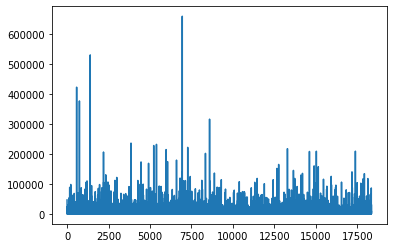

In [62]:
data = MEPSDataset().data()
data.reset_index(drop=True, inplace=True)
data.drop(columns= ['PANEL', 'PERSONWT'], inplace=True)
data_filtered = data[data['HEALTHEXP'] < 150000]
plt.plot(data.HEALTHEXP)

In [119]:
cols = data.columns
categoricalCols = [
    'REGION','GENDER', 'RACE3', 'MARRY31X','EDRECODE','FTSTU31X','ACTDTY31','HONRDC31',
    'RTHLTH31','MNHLTH31','HIBPDX','CHDDX','ANGIDX','MIDX','OHRTDX','STRKDX','EMPHDX',
    'CHBRON31','CHOLDX','CANCERDX','DIABDX','JTPAIN31','ARTHDX', 'ARTHTYPE','ASTHDX',
    'ADHDADDX','PREGNT31','WLKLIM31','ACTLIM31','SOCLIM31','COGLIM31','DFHEAR42',
    'DFSEE42','ADSMOK42','PHQ242','EMPST31','POVCAT15','INSCOV15'
]
X, y = data.drop({'HEALTHEXP'}, 1), data['HEALTHEXP']
X_cat = X.copy()
for cat in categoricalCols:
    X_cat[cat] = X_cat[cat].astype('int')

In [120]:
def score_r2_print(clf, X_train, X_test, y_train, y_test):
    print('Training R^2:', r2_score(y_train, clf.predict(X_train)))
    print('Test R^2:', r2_score(y_test, clf.predict(X_test)))

In [121]:
X_train, X_test, y_train, y_test = train_test_split(X_cat, y, test_size=0.2, random_state=37)

# 1 Training models

## 1.1. Linear Regression

In [122]:
slr = LinearRegression()
slr.fit(X_train, y_train)
score_r2_print(slr, X_train, X_test, y_train, y_test)

Training R^2: 0.13815388907360537
Test R^2: 0.1776970270831072


In [123]:
y_test_pred = slr.predict(X_test)
y_train_pred = slr.predict(X_train)

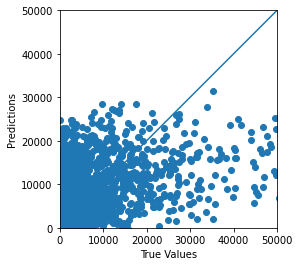

In [124]:
a = plt.axes(aspect='equal')
plt.scatter(y_test, y_test_pred)
plt.xlabel('True Values')
plt.ylabel('Predictions')
lims = [0, 50000]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

# 1.2. RandomForestRegressor

In [125]:
from sklearn.ensemble import RandomForestRegressor

tree = RandomForestRegressor(
    n_estimators=900, 
    criterion='mse', 
    random_state=1,
    max_features="sqrt",
    n_jobs=-1)
tree.fit(X_train, y_train)
score_r2_print(tree, X_train, X_test, y_train, y_test)

Training R^2: 0.881080381454145
Test R^2: 0.18780782607953128


## 1.3. GradientBoostingRegressor

In [126]:
gbr = GradientBoostingRegressor(n_estimators=200, random_state=7, max_features="log2")
gbr.fit(X_train, y_train)

score_r2_print(gbr, X_train, X_test, y_train, y_test)

Training R^2: 0.35682813592631
Test R^2: 0.19676710164305644


# 2. Variable importance

In [127]:
def predict_function(model, data):
    return model.predict(data)

In [173]:
exp_gbr = dx.Explainer(gbr, X_test, y_test, predict_function=predict_function, label='GradientBoostingRegressor')

Preparation of a new explainer is initiated

  -> data              : 3670 rows 43 cols
  -> target variable   : Argument 'y' was a pandas.Series. Converted to a numpy.ndarray.
  -> target variable   : 3670 values
  -> model_class       : sklearn.ensemble._gb.GradientBoostingRegressor (default)
  -> label             : GradientBoostingRegressor
  -> predict function  : <function predict_function at 0x1c8080830> will be used
  -> predicted values  : min = -4994.610647713694, mean = 5426.865425442358, max = 90340.6300457942
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -89892.6300457942, mean = -426.9678777584338, max = 285222.82490959356
  -> model_info        : package sklearn

A new explainer has been created!


# 2.1 Gradient Boosting Regressor model performance

In [174]:
mp_gbr = exp_gbr.model_performance("regression")
mp_gbr.result

,mse,rmse,r2,mae,mad
0,1.448404e+08,12034.963769,0.196767,4960.09368,2180.022726


In [175]:
vi_gbr = exp_gbr.model_parts()

In [176]:
vi_gbr.plot(max_vars=50, rounding_function=np.rint, digits=None, vertical_spacing=0.15)

# 2.2 Random Forest Regression model performance

In [190]:
exp_rf = dx.Explainer(tree, X_test, y_test, predict_function=predict_function, label='LinearRegression')


Preparation of a new explainer is initiated

  -> data              : 3670 rows 43 cols
  -> target variable   : Argument 'y' was a pandas.Series. Converted to a numpy.ndarray.
  -> target variable   : 3670 values
  -> model_class       : sklearn.ensemble._forest.RandomForestRegressor (default)
  -> label             : LinearRegression
  -> predict function  : <function predict_function at 0x1c8080830> will be used
  -> predicted values  : min = 27.08353960364254, mean = 5730.65729768756, max = 45910.73222222222
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -45627.73222222222, mean = -730.7597500036354, max = 289922.6566666667
  -> model_info        : package sklearn

A new explainer has been created!


In [191]:
mp_rf = exp_slr.model_performance("regression")
mp_rf.result

,mse,rmse,r2,mae,mad
0,1.482791e+08,12176.990676,0.177697,5381.631944,2875.497989


In [192]:
vi_rf = exp_rf.model_parts()

In [193]:
vi_rf.plot(max_vars=50, rounding_function=np.rint, digits=None, vertical_spacing=0.15)

In [202]:
selected_variables = ['PCS42', 'MCS42', 'K6SUM42', 'PHQ242', 'ARTHYPE', 'INCOME_M', 'CANCERDX', 'AGE31X']